# Stellargraph example: Heterogeneous GraphSAGE on the Movielens recommendation dataset

In this example, we use our generalisation of the [GraphSAGE](http://snap.stanford.edu/graphsage/) algorithm to heterogeneous graphs (which we call HinSAGE) to build a model that predicts user-movie ratings in the Movielens dataset (see below). The problem is treated as a supervised link attribute inference problem on a user-movie network with nodes of two types (users and movies, both attributed) and links corresponding to user-movie ratings, with integer `rating` attributes from 1 to 5 (note that if a user hasn't rated a movie, the corresponding user-movie link does not exist in the network).

To address this problem, we build a model with the following architecture: a two-layer HinSAGE model that takes labeled `(user, movie)` node pairs corresponding to user-movie ratings, and outputs a pair of node embeddings for the `user` and `movie` nodes of the pair. These embeddings are then fed into a link regression layer, which applies a binary operator to those node embeddings (e.g., concatenating them) to construct the link embedding. Thus obtained link embeddings are passed through the link regression layer to obtain predicted user-movie ratings. The entire model is trained end-to-end by minimizing the loss function of choice (e.g., root mean square error between predicted and true ratings) using stochastic gradient descent (SGD) updates of the model parameters, with minibatches of user-movie training links fed into the model.

In [1]:
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from keras import Model, optimizers, losses, metrics

import multiprocessing

Using TensorFlow backend.


In [2]:
import utils

In this example we use the movielens dataset ml-100k that can be downloaded [here](https://grouplens.org/datasets/movielens/100k/). The dataset contains 100,000 ratings from 943 users on 1682 movies.

In [3]:
with open("ml-100k-config.json", "r") as f:
    config = json.load(f)

The data path below assumes that the dataset has been downloaded and unzipped into '~/data/ml-100k/' directory.

In [4]:
data_path = "~/data/ml-100k/"

Ingest the ratings into a user-movie graph:

In [5]:
Gnx, id_map, inv_id_map = utils.ingest_graph(data_path, config)

Graph statistics: 943 users, 1682 movies, 100000 ratings


Ingest user and movie features:

In [6]:
user_features = utils.ingest_features(data_path, config, node_type="users")
movie_features = utils.ingest_features(data_path, config, node_type="movies")

Explore user and movie features:

In [7]:
user_features.head()

,age,gender,job
uId,,,
1,24,M,technician
2,53,F,other
3,23,M,writer
4,24,M,technician
5,33,F,other


In [8]:
movie_features.head()

,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18,g19
mId,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


Prepare the user features for machine learning (ML) by transforming them to numeric feature vectors required by the HinSAGE model (movie features are already numeric and hence ML-ready):

In [9]:
# Names of user features than require transforming to numeric features:
feature_names = ["age", "gender", "job"]

feature_encoding = feature_extraction.DictVectorizer(sparse=False, dtype=float)
user_features_transformed = feature_encoding.fit_transform(user_features[feature_names].to_dict('records'))

# Assume that the age can be used as a continuous variable and rescale it
user_features_transformed[:, 0] = preprocessing.scale(user_features_transformed[:, 0])

# Put features back in DataFrame
user_features = pd.DataFrame(
    user_features_transformed, index=user_features.index, dtype="float64"
)

Add the user and movie features to the graph:

In [10]:
Gnx = utils.add_features_to_nodes(Gnx, inv_id_map, user_features, movie_features)

Split Gnx.edges() into train and test sets for model training/evaluation:

In [11]:
edges = list(Gnx.edges(data=True))

In [12]:
# Use 70% of edges for training, the rest for testing:
edges_train, edges_test = model_selection.train_test_split(edges, train_size=0.7, test_size=0.3)

edgelist_train = [(e[0],e[1]) for e in edges_train]
edgelist_test = [(e[0],e[1]) for e in edges_test]

labels_train = [e[2]["score"] for e in edges_train]
labels_test = [e[2]["score"] for e in edges_test]

Our machine learning task of learning user-movie ratings can be framed as a supervised Link Attribute Inference: given a graph of user-movie ratings, we train a model for rating prediction using the ratings edges_train, and evaluate it using the test ratings edges_test. The model also requires the user-movie graph structure, to do the neighbour sampling required by the HinSAGE algorithm.

To proceed, we need to create a StellarGraph object from the ingested graph, for training the model:

In [13]:
# When sampling the GraphSAGE subgraphs, we want to treat user-movie links as undirected
G = sg.StellarGraph(Gnx, node_features="feature")

Now we are ready for our ML task of learning to predict user-movie ratings!

Summary of the prepared ML-ready StellarGraph:

In [14]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2625, Edges: 100000

 Node types:
  movie: [1682]
        Attributes: {'feature'}
    Edge types: movie-default->user
  user: [943]
        Attributes: {'feature'}
    Edge types: user-default->movie

 Edge types:
    movie-default->user: [74198]
        Attributes: {'uId', 'mId', 'score'}
    user-default->movie: [25802]
        Attributes: {'uId', 'mId', 'score'}



Next, we create the link mappers for sampling and streaming training and testing data to the model. The link mappers essentially "map" user-movie links to the input of HinSAGE: they take minibatches of user-movie links, sample 2-hop subgraphs of G with `(user, movie)` head nodes extracted from those user-movie links, and feed them, together with the corresponding user-movie ratings, to the input layer of the HinSAGE model, for SGD updates of the model parameters.

Specify the minibatch size (number of user-movie links per minibatch) and the number of epochs for training the ML model:

In [15]:
batch_size = 200
epochs = 20

Specify the sizes of 1- and 2-hop neighbour samples for HinSAGE:

Note that the length of `num_samples` list defines the number of layers/iterations in the HinSAGE model.

In [16]:
num_samples = [8, 4]

Create the mappers:

In [17]:
generator = HinSAGELinkGenerator(
            G,
            batch_size,
            num_samples,
        )
train_gen = generator.flow(edgelist_train, labels_train)
test_gen = generator.flow(edgelist_test, labels_test)

Build the model by stacking a two-layer HinSAGE model and a link regression layer on top.

First, we define the HinSAGE part of the model, with hidden layer sizes of 32 for both HinSAGE layers, a bias term, and no dropout. (Dropout can be switched on by specifying a positive `dropout` rate, `0 < dropout < 1`)

Note that the length of `layer_sizes` list must be equal to the length of `num_samples`, as `len(num_samples)` defines the number of hops (layers) in the HinSAGE model.

In [18]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(layer_sizes=hinsage_layer_sizes, 
                  generator=train_gen, 
                  bias=True, 
                  dropout=0.0)

In [19]:
# Expose input and output sockets of hinsage:
x_inp, x_out = hinsage.default_model()

Add the final estimator layer for predicting the ratings. The edge_embedding_method argument specifies the way in which node representations (node embeddings) are combined into link representations (recall that links represent user-movie ratings, and are thus pairs of (user, movie) nodes). In this example, we will use 'concat', i.e., node embeddings are concatenated to get link embeddings.

In [20]:
# Final estimator layer
score_prediction = link_regression(edge_embedding_method='concat')(x_out)

link_regression: using 'concat' method to combine node embeddings into edge embeddings


Create the Keras model, and compile it by specifying the optimizer, loss function to optimise, and metrics for diagnostics:

In [21]:
import keras.backend as K
def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))

model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(
    optimizer=optimizers.Adam(lr=1e-2),
    loss=losses.mean_squared_error,
    metrics=[root_mean_square_error, metrics.mae],
)

Summary of the model:

In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 8, 19)        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 32, 24)       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 32, 19)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1, 24)        0                                            
__________________________________________________________________________________________________
reshape_1 

In [23]:
# Specify the number of workers to use for model training (relevant only when multiprocessing=True)
num_workers = multiprocessing.cpu_count()//2

Evaluate the fresh (untrained) model on the test set (for reference):

In [24]:
test_metrics = model.evaluate_generator(test_gen, verbose=1, use_multiprocessing=True, workers=num_workers)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

150/150 [==============================] - 4s 26ms/step
Untrained model's Test Evaluation:
	loss: 11.5802
	root_mean_square_error: 3.4021
	mean_absolute_error: 3.2114


Train the model by feeding the data from the graph in minibatches, using mapper_train, and get validation metrics after each epoch:

In [25]:
history = model.fit_generator(
            train_gen,
            validation_data=test_gen,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            use_multiprocessing=True,
            workers=num_workers,
        )

Epoch 1/20
350/350 [==============================] - 14s 40ms/step - loss: 1.3476 - root_mean_square_error: 1.1359 - mean_absolute_error: 0.9410 - val_loss: 1.1537 - val_root_mean_square_error: 1.0730 - val_mean_absolute_error: 0.8686
Epoch 2/20
350/350 [==============================] - 13s 38ms/step - loss: 1.1490 - root_mean_square_error: 1.0706 - mean_absolute_error: 0.8709 - val_loss: 1.1287 - val_root_mean_square_error: 1.0613 - val_mean_absolute_error: 0.8605
Epoch 3/20
350/350 [==============================] - 13s 38ms/step - loss: 1.1306 - root_mean_square_error: 1.0620 - mean_absolute_error: 0.8614 - val_loss: 1.1220 - val_root_mean_square_error: 1.0581 - val_mean_absolute_error: 0.8495
Epoch 4/20
350/350 [==============================] - 13s 38ms/step - loss: 1.1226 - root_mean_square_error: 1.0582 - mean_absolute_error: 0.8571 - val_loss: 1.1192 - val_root_mean_square_error: 1.0568 - val_mean_absolute_error: 0.8632
Epoch 5/20
350/350 [==============================] - 13

Plot the training history:

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()

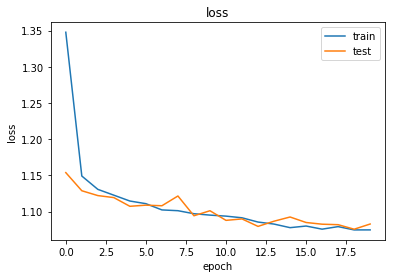

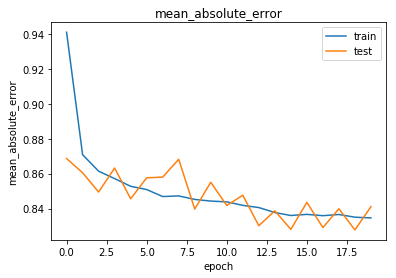

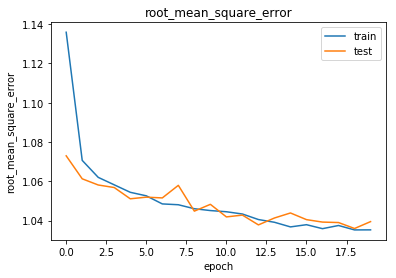

In [27]:
plot_history(history)

Evaluate the trained model on test user-movie rankings:

In [28]:
test_metrics = model.evaluate_generator(test_gen, use_multiprocessing=True, workers=num_workers, verbose=1)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

150/150 [==============================] - 4s 25ms/step
Test Evaluation:
	loss: 1.0823
	root_mean_square_error: 1.0392
	mean_absolute_error: 0.8404


Compare the predicted test rankings with "mean baseline" rankings, to see how much better our model does compared to this (very simplistic) baseline:

In [29]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = model.predict_generator(test_gen)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, np.mean(y_true))

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  1.1235099267721476
	mean_absolute_error =  0.9411109962304434

Model Test set metrics:
	root_mean_square_error =  1.0401720009469817
	mean_absolute_error =  0.839939950633049


Compare the distributions of predicted and true rankings for the test set:

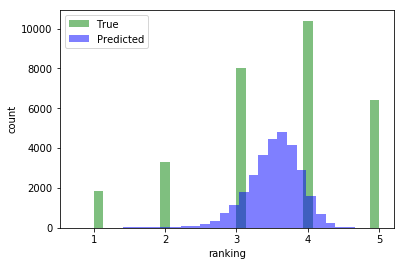

In [30]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True","Predicted"))
plt.show()

We see that our model beats the "mean baseline" by a significant margin. To further improve the model, you can try increasing the number of training epochs, change the dropout rate, change the sample sizes for subgraph sampling `num_samples`, hidden layer sizes `layer_sizes` of the HinSAGE part of the model, or try increasing the number of HinSAGE layers.

However, note that the distribution of predicted scores is still very narrow, and rarely gives 1, 2 or 5 as a score.

This model uses a bipartite user-movie graph to learn to predict movie ratings. It can be further enhanced by using additional relations, e.g., friendships between users, if they become available. And the best part is: the underlying algorithm of the model does not need to change at all to take these extra relations into account - all that changes is the graph that it learns from!